# Cas d'Étude : comptage de cellules par segmentation avancée

Le comptage d'objets dans une image est une tâche courante en analyse d'images, notamment en microscopie. Cependant, un simple seuillage est souvent insuffisant lorsque les objets d'intérêt sont connectés ou se chevauchent.

Ce chapitre présente un pipeline d'analyse d'images plus robuste pour le comptage de cellules, en utilisant l'**algorithme du bassin versant (watershed)** pour séparer les objets adjacents et obtenir une segmentation précise.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io, color, feature, filters, measure, segmentation


---

## 1. Chargement et prétraitement de l'image

Le prétraitement est une étape cruciale pour améliorer la qualité de l'image avant la segmentation :
1.  **Chargement** : L'image est chargée.
2.  **Conversion en Niveaux de Gris** : Les informations de couleur sont souvent superflues pour le comptage d'objets et peuvent être supprimées.
3.  **Flou Gaussien** : Un léger flou est appliqué pour réduire le bruit et lisser les contours, ce qui facilite les étapes de segmentation ultérieures.

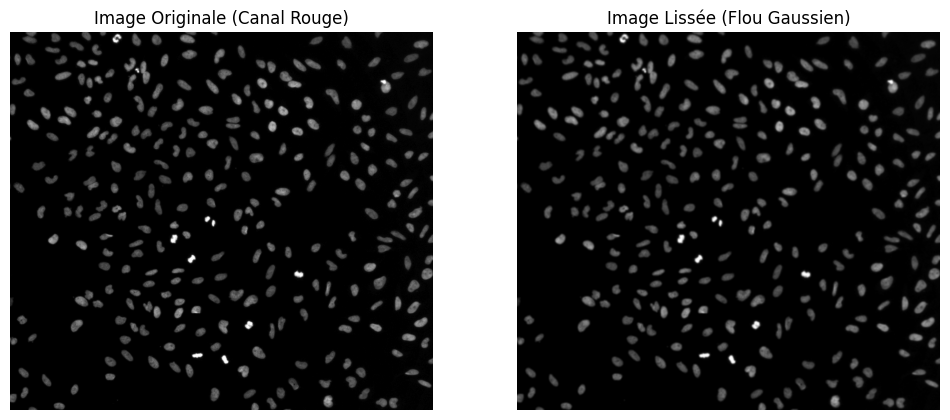

In [ ]:
# Chargement de l'image de cellules (canal rouge pour un meilleur contraste)
image_rgb = io.imread('data/cells.png')
image_gris = image_rgb[:, :, 0] # Sélection du canal rouge

# Application d'un flou gaussien
image_floue = filters.gaussian(image_gris, sigma=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_gris, cmap='gray')
axes[0].set_title("Image Originale (Canal Rouge)")
axes[0].axis('off')

axes[1].imshow(image_floue, cmap='gray')
axes[1].set_title("Image Lissée (Flou Gaussien)")
axes[1].axis('off')
plt.show()

---

## 2. Segmentation par seuillage d'otsu

Pour séparer les cellules de l'arrière-plan, nous utilisons le **seuillage d'Otsu**. Cette méthode adaptative détermine automatiquement un seuil optimal pour binariser l'image, en maximisant la variance inter-classes des pixels (cellules vs. fond). Cela est particulièrement utile lorsque la distribution des intensités n'est pas uniforme.

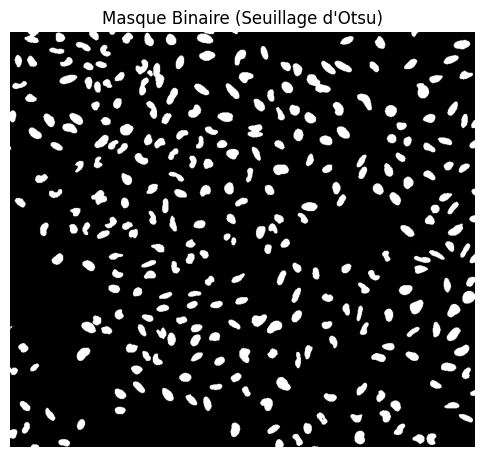

In [ ]:
# Calcul du seuil optimal avec la méthode d'Otsu
seuil_otsu = filters.threshold_otsu(image_floue)
masque_binaire = image_floue > seuil_otsu

plt.figure(figsize=(6, 6))
plt.imshow(masque_binaire, cmap='gray')
plt.title("Masque Binaire (Seuillage d'Otsu)")
plt.axis('off')
plt.show()

---

## 3. Séparation des objets connectés : Algorithme Watershed

Un défi courant est la séparation des objets qui se touchent dans le masque binaire. L'**algorithme du bassin versant (watershed)** est une technique puissante pour résoudre ce problème. Il fonctionne en trois étapes principales :

1.  **Transformée en Distance** : Calcul de la distance de chaque pixel blanc au pixel noir le plus proche. Les centres des objets apparaissent comme des maxima locaux.
2.  **Identification des Marqueurs** : Détection de ces maxima locaux, qui serviront de "graines" pour chaque objet.
3.  **Application du Watershed** : L'algorithme simule l'inondation d'un paysage (l'image de distance) à partir des marqueurs. Les lignes de crête où les "eaux" se rencontrent définissent les frontières entre les objets.

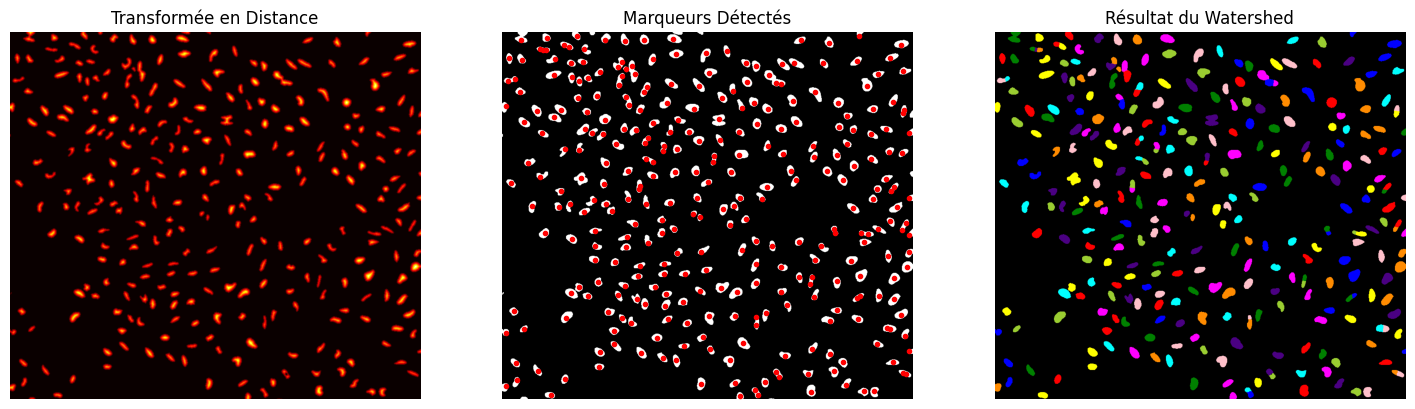

In [ ]:
# 1. Calcul de la transformée en distance euclidienne
distance = ndi.distance_transform_edt(masque_binaire)

# 2. Identification des marqueurs (maxima locaux) avec une distance minimale entre eux
coords_pics = feature.peak_local_max(distance, min_distance=7, labels=masque_binaire)
masque_marqueurs = np.zeros(distance.shape, dtype=bool)
masque_marqueurs[tuple(coords_pics.T)] = True
marqueurs, _ = ndi.label(masque_marqueurs)

# 3. Application de l'algorithme du bassin versant
etiquettes_watershed = segmentation.watershed(-distance, marqueurs, mask=masque_binaire)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(distance, cmap='hot')
axes[0].set_title("Transformée en Distance")
axes[0].axis('off')

axes[1].imshow(masque_binaire, cmap='gray')
axes[1].plot(coords_pics[:, 1], coords_pics[:, 0], 'r.')
axes[1].set_title("Marqueurs Détectés")
axes[1].axis('off')

axes[2].imshow(color.label2rgb(etiquettes_watershed, bg_label=0))
axes[2].set_title("Résultat du Watershed")
axes[2].axis('off')
plt.show()

---

## 4. Comptage et visualisation finale

Une fois les objets segmentés et étiquetés par l'algorithme du bassin versant, le comptage est direct : il correspond au nombre d'étiquettes uniques (en excluant l'étiquette 0, qui représente l'arrière-plan). La visualisation finale permet de superposer les objets détectés sur l'image originale pour une validation qualitative.

Nombre total de cellules détectées : 314


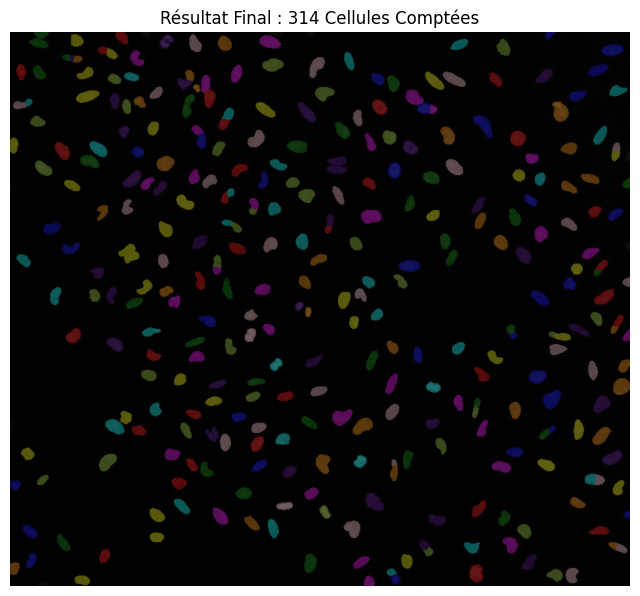

In [ ]:
# Comptage du nombre d'objets (cellules)
nb_cellules = len(np.unique(etiquettes_watershed)) - 1 # Soustraire 1 pour l'arrière-plan (étiquette 0)
print(f"Nombre total de cellules détectées : {nb_cellules}")

# Création d'une image de visualisation avec les objets colorés sur l'image originale
image_resultat_visuelle = color.label2rgb(etiquettes_watershed, image=image_gris, bg_label=0, alpha=0.3)

plt.figure(figsize=(8, 8))
plt.imshow(image_resultat_visuelle)
plt.title(f"Résultat Final : {nb_cellules} Cellules Comptées")
plt.axis('off')
plt.show()